<a href="https://colab.research.google.com/github/faithNassiwa/predictive-diagnosis-assistant/blob/main/notebooks/DDXPlus_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from sklearn.utils import class_weight

In [5]:
# Mount google drive to access folder with data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Read the training and test dataset -- Took a minute

train_df = pd.read_csv('/content/drive/MyDrive/DS5500/Data/Dataset2/processed_train.csv', low_memory=False)
test_df = pd.read_csv('/content/drive/MyDrive/DS5500/Data/Dataset2/processed_test.csv', low_memory=False)
pprint(f'Train dataset shape: {train_df.shape}')
pprint(f'Test dataset shape: {test_df.shape}')

'Train dataset shape: (1025602, 221)'
'Test dataset shape: (134529, 221)'


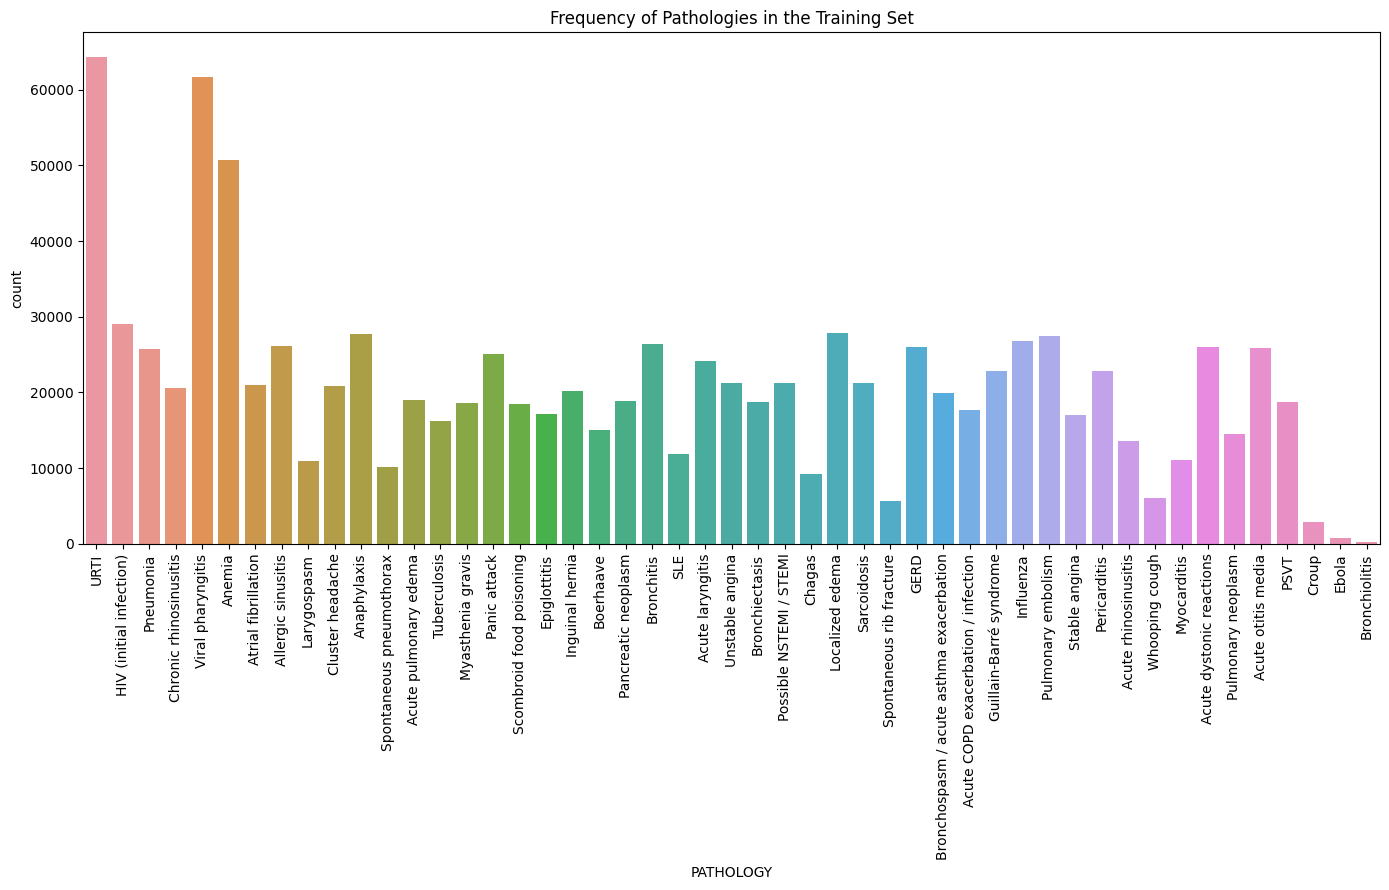

In [7]:
# Check for data balance
plt.figure(figsize=(14,9))
sns.countplot(x='PATHOLOGY', data=train_df)
plt.title('Frequency of Pathologies in the Training Set')
plt.xticks(rotation=90)
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('pathology_count.png')

# Display the plot
plt.show()

Dataset is imbalanced. Need to explore more.

In [8]:
# Info about data and categorical columns
train_df.info()
categorical_column_data_types = {col: train_df[col].dtype for col in train_df.columns if train_df[col].dtype == 'O'}
pprint(categorical_column_data_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025602 entries, 0 to 1025601
Columns: 221 entries, Unnamed: 0 to Are you of Asian descent?
dtypes: float64(208), int64(2), object(11)
memory usage: 1.7+ GB
{'Characterize your pain:': dtype('O'),
 'Do you feel pain somewhere?': dtype('O'),
 'Do your lesions peel off?': dtype('O'),
 'Does the pain radiate to another location?': dtype('O'),
 'Have you traveled out of the country in the last 4 weeks?': dtype('O'),
 'Is the lesion (or are the lesions) larger than 1cm?': dtype('O'),
 'PATHOLOGY': dtype('O'),
 'SEX': dtype('O'),
 'What color is the rash?': dtype('O'),
 'Where is the affected region located?': dtype('O'),
 'Where is the swelling located?': dtype('O')}


We have 10 categorical columns that need to encoded.

In [9]:
# View values of categorical columns
unique_values = {col: train_df[col].unique() for col in train_df.columns if train_df[col].dtype == 'O'}
pprint(unique_values)


{'Characterize your pain:': array(['heavy', 'exhausting', 'sharp', 'burning', 'a cramp', '0',
       'heartbreaking', 'sickening', 'sensitive', 'scary',
       'a knife stroke', 'tugging', 'violent', 'a pulse', 'haunting',
       'tedious', nan], dtype=object),
 'Do you feel pain somewhere?': array(['temple(L)', 'posterior chest wall(L)', 'eye(R)', 'pharynx', '0',
       'temple(R)', 'epigastric', 'breast(L)', 'iliac fossa(L)', 'pubis',
       'occiput', 'testicle(L)', 'posterior chest wall(R)', 'shoulder(L)',
       'under the jaw', 'hypochondrium(R)', 'forehead', 'trachea',
       'sole(L)', 'finger (middle)(R)', 'shoulder(R)', 'breast(R)',
       'dorsal aspect of the foot(L)', 'belly', 'eye(L)', 'nose',
       'hip(L)', 'top of the head', 'triceps(R)', 'finger (middle)(L)',
       'ear(L)', 'ear(R)', 'nowhere', 'sole(R)', 'upper chest',
       'cheek(L)', 'hypochondrium(L)', 'knee(R)', 'back of head',
       'palace', 'testicle(R)', 'lower chest',
       'dorsal aspect of the foot(

In [10]:
# Check if there are any nans values
pprint(train_df.columns[train_df.isna().any()].tolist())
pprint(test_df.columns[test_df.isna().any()].tolist())

['Characterize your pain:', 'What color is the rash?']
['Characterize your pain:', 'What color is the rash?']


In [11]:
# Count of NAN in the columns -- drop these rows

print(train_df['Characterize your pain:'].isna().sum())
print(train_df['What color is the rash?'].isna().sum())
print(test_df['Characterize your pain:'].isna().sum())
print(test_df['What color is the rash?'].isna().sum())

10859
32609
1379
4436


In [12]:
# Drop rows with NAN values

train_df_nonan = train_df.dropna(subset=['Characterize your pain:', 'What color is the rash?'])
test_df_nonan = test_df.dropna(subset=['Characterize your pain:', 'What color is the rash?'])

In [13]:
# Count of NAN in the columns after drop

print(train_df_nonan['Characterize your pain:'].isna().sum())
print(train_df_nonan['What color is the rash?'].isna().sum())
print(test_df_nonan['Characterize your pain:'].isna().sum())
print(test_df_nonan['What color is the rash?'].isna().sum())

0
0
0
0


In [14]:
pprint(f'Train dataset shape: {train_df_nonan.shape}')
pprint(f'Test dataset shape: {test_df_nonan.shape}')

'Train dataset shape: (982224, 221)'
'Test dataset shape: (128726, 221)'


In [17]:
# Remove columns with one value
train_df_nonan.drop(columns=['Have you lost consciousness associated with violent and sustained muscle contractions or had an absence episode?',
                             'Have you noticed a diffuse (widespread) redness in one or both eyes?',
                             'Have you had any vaginal discharge?'], inplace=True)
test_df_nonan.drop(columns=['Have you lost consciousness associated with violent and sustained muscle contractions or had an absence episode?',
                             'Have you noticed a diffuse (widespread) redness in one or both eyes?',
                             'Have you had any vaginal discharge?'], inplace=True)

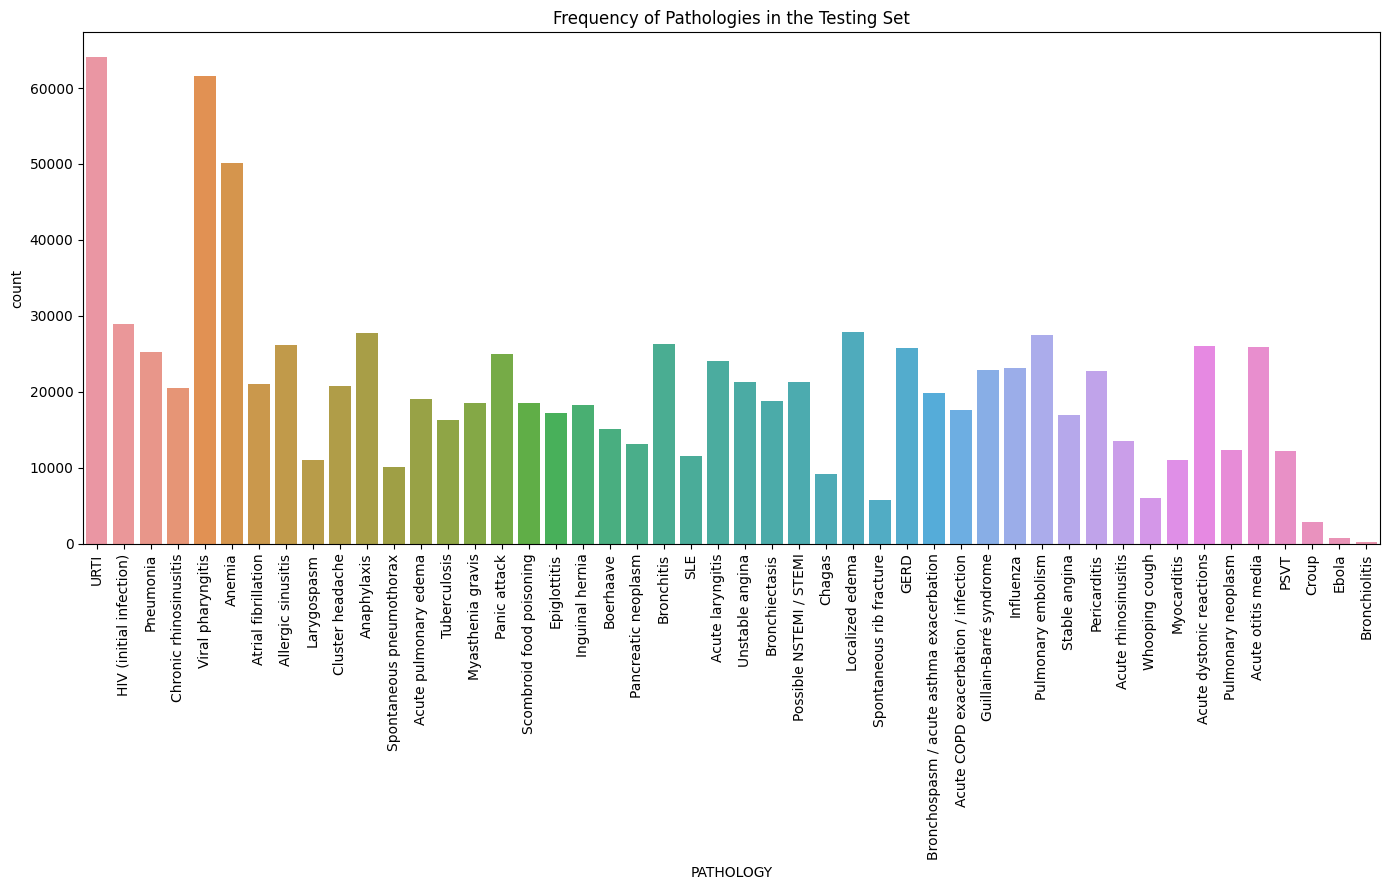

In [18]:
# Check for data balance - After dropping NAN rows
plt.figure(figsize=(14,9))
sns.countplot(x='PATHOLOGY', data=train_df_nonan)
plt.title('Frequency of Pathologies in the Testing Set')
plt.xticks(rotation=90)
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('pathology_count_train.png')

# Display the plot
plt.show()

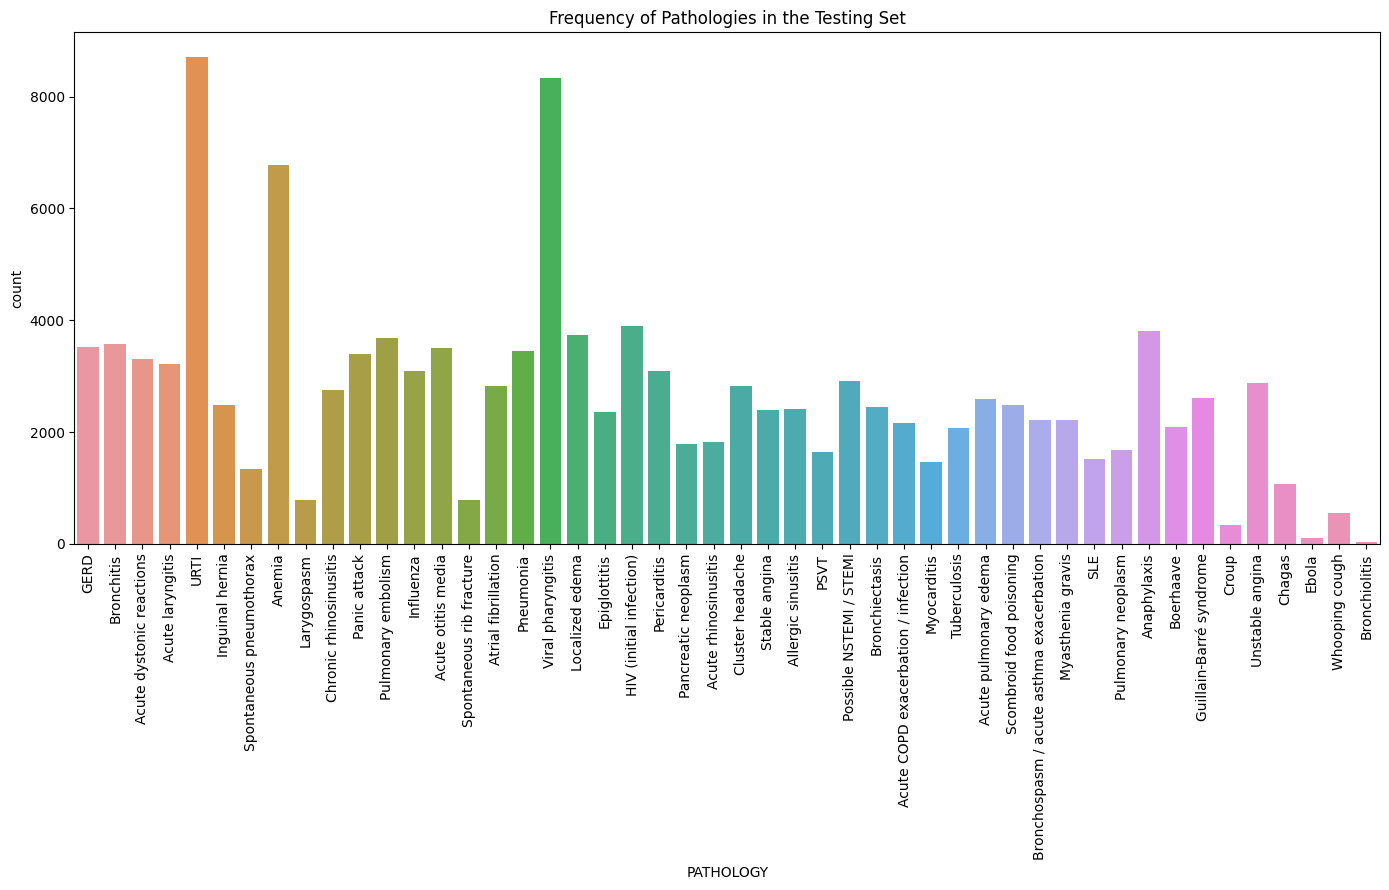

In [19]:
# Check for data balance - After dropping NAN rows
plt.figure(figsize=(14,9))
sns.countplot(x='PATHOLOGY', data=test_df_nonan)
plt.title('Frequency of Pathologies in the Testing Set')
plt.xticks(rotation=90)
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('pathology_count_test.png')

# Display the plot
plt.show()

In [20]:
# Prepare training and test variables
X_columns = [col for col in train_df_nonan.columns if col not in ['Unnamed: 0', 'PATHOLOGY']]
X_train = train_df_nonan[X_columns]
y_train = train_df_nonan['PATHOLOGY']
X_test = test_df_nonan[X_columns]
y_test = test_df_nonan['PATHOLOGY']
pprint(f'X_train shape: {X_train.shape}')
pprint(f'y_train shape: {y_train.shape}')
pprint(f'X_test shape: {X_test.shape}')
pprint(f'y_test shape: {y_test.shape}')


'X_train shape: (982224, 216)'
'y_train shape: (982224,)'
'X_test shape: (128726, 216)'
'y_test shape: (128726,)'


In [21]:
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
le = LabelEncoder()

categorical_columns = list(unique_values.keys())
# Remove Pathology column - Not needed for Decision Trees
categorical_columns.remove('PATHOLOGY')

# Reset indices of both X_train and X_test
X_train_reset = X_train.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Combine the train and test data
combined = pd.concat([X_train_reset, X_test_reset], axis=0)

# Label encode the combined dataframe for each categorical column
for col in categorical_columns:
  combined[col] = le.fit_transform(combined[col])

combined_encoded = combined

# Split the combined_encoded dataframe back into train and test
X_train_encoded = combined_encoded.iloc[:len(X_train)]
X_test_encoded = combined_encoded.iloc[len(X_train):]

In [22]:
# Check dimension after encoding
pprint(f'X_train shape: {X_train_encoded.shape}')
pprint(f'X_test shape: {X_test_encoded.shape}')

'X_train shape: (982224, 216)'
'X_test shape: (128726, 216)'


In [23]:
# Decision Tree Model -- Took about 20 seconds

# Initialize and fit the model
clf = DecisionTreeClassifier(random_state=420, class_weight='balanced')
clf.fit(X_train_encoded, y_train)

# make predictions
y_pred = clf.predict(X_test_encoded)

In [24]:
# Evaluate the Model

# Encode y_values for auc_score
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_2d = lb.fit_transform(y_test)
y_pred_2d = lb.fit_transform(y_pred)

# Compute scores
accuracy = accuracy_score(y_test, y_pred)
auc_score_ovo = roc_auc_score(y_test_2d, y_pred_2d, multi_class='ovo')
auc_score_ovr = roc_auc_score(y_test_2d, y_pred_2d, multi_class='ovr')

# Print scores
print(f'The accuracy score is {accuracy * 100:.2f}%')
print(f'One-vs-One AUC score: {auc_score_ovo * 100:.2f}%')
print(f'One-vs-Rest AUC score: {auc_score_ovr * 100:.2f}%')
print("Classification Report")
print(classification_report(y_test, y_pred))

The accuracy score is 99.13%
One-vs-One AUC score: 99.49%
One-vs-Rest AUC score: 99.49%
Classification Report
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       1.00      1.00      1.00      2153
                Acute dystonic reactions       1.00      1.00      1.00      3302
                        Acute laryngitis       0.99      0.99      0.99      3214
                      Acute otitis media       1.00      1.00      1.00      3509
                   Acute pulmonary edema       1.00      1.00      1.00      2598
                    Acute rhinosinusitis       0.73      0.78      0.76      1829
                      Allergic sinusitis       1.00      1.00      1.00      2411
                             Anaphylaxis       1.00      1.00      1.00      3798
                                  Anemia       1.00      1.00      1.00      6770
                     Atrial fibrillation       1.00      1.00      1.

In [25]:
# Perform Cross Validation -- Took 12 minutes
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

## using RandomizedSearchCV instead of GridSearchCV due to a wide range of hyperparameters
## to explore without exhuatively searching the entire grid saving on computation time

X = X_train_encoded
y = y_train

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3,10),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5, None]

}

# Initialize model and cross validation
clf = DecisionTreeClassifier()
random_search = RandomizedSearchCV(clf,
                                   param_distributions=params,
                                   n_iter=100, # number of parameter settings to sample
                                   cv=5, # number of folds
                                   refit=True,
                                   scoring='accuracy',
                                   n_jobs= -1 , # use all cores for faster computation
                                   verbose = 1, # to see progress, set to 0 for no output or 2 for detailed output
                                   random_state=42 # for reproducibility
                                   )


# fit cv
random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='accuracy', verbose=1)

In [26]:
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Score: {random_search.best_score_}')
print(f'Best Tree: {random_search.best_estimator_}')

Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 9, 'criterion': 'entropy'}
Best Score: 0.8800070034751855
Best Tree: DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5,
                       min_samples_split=20)


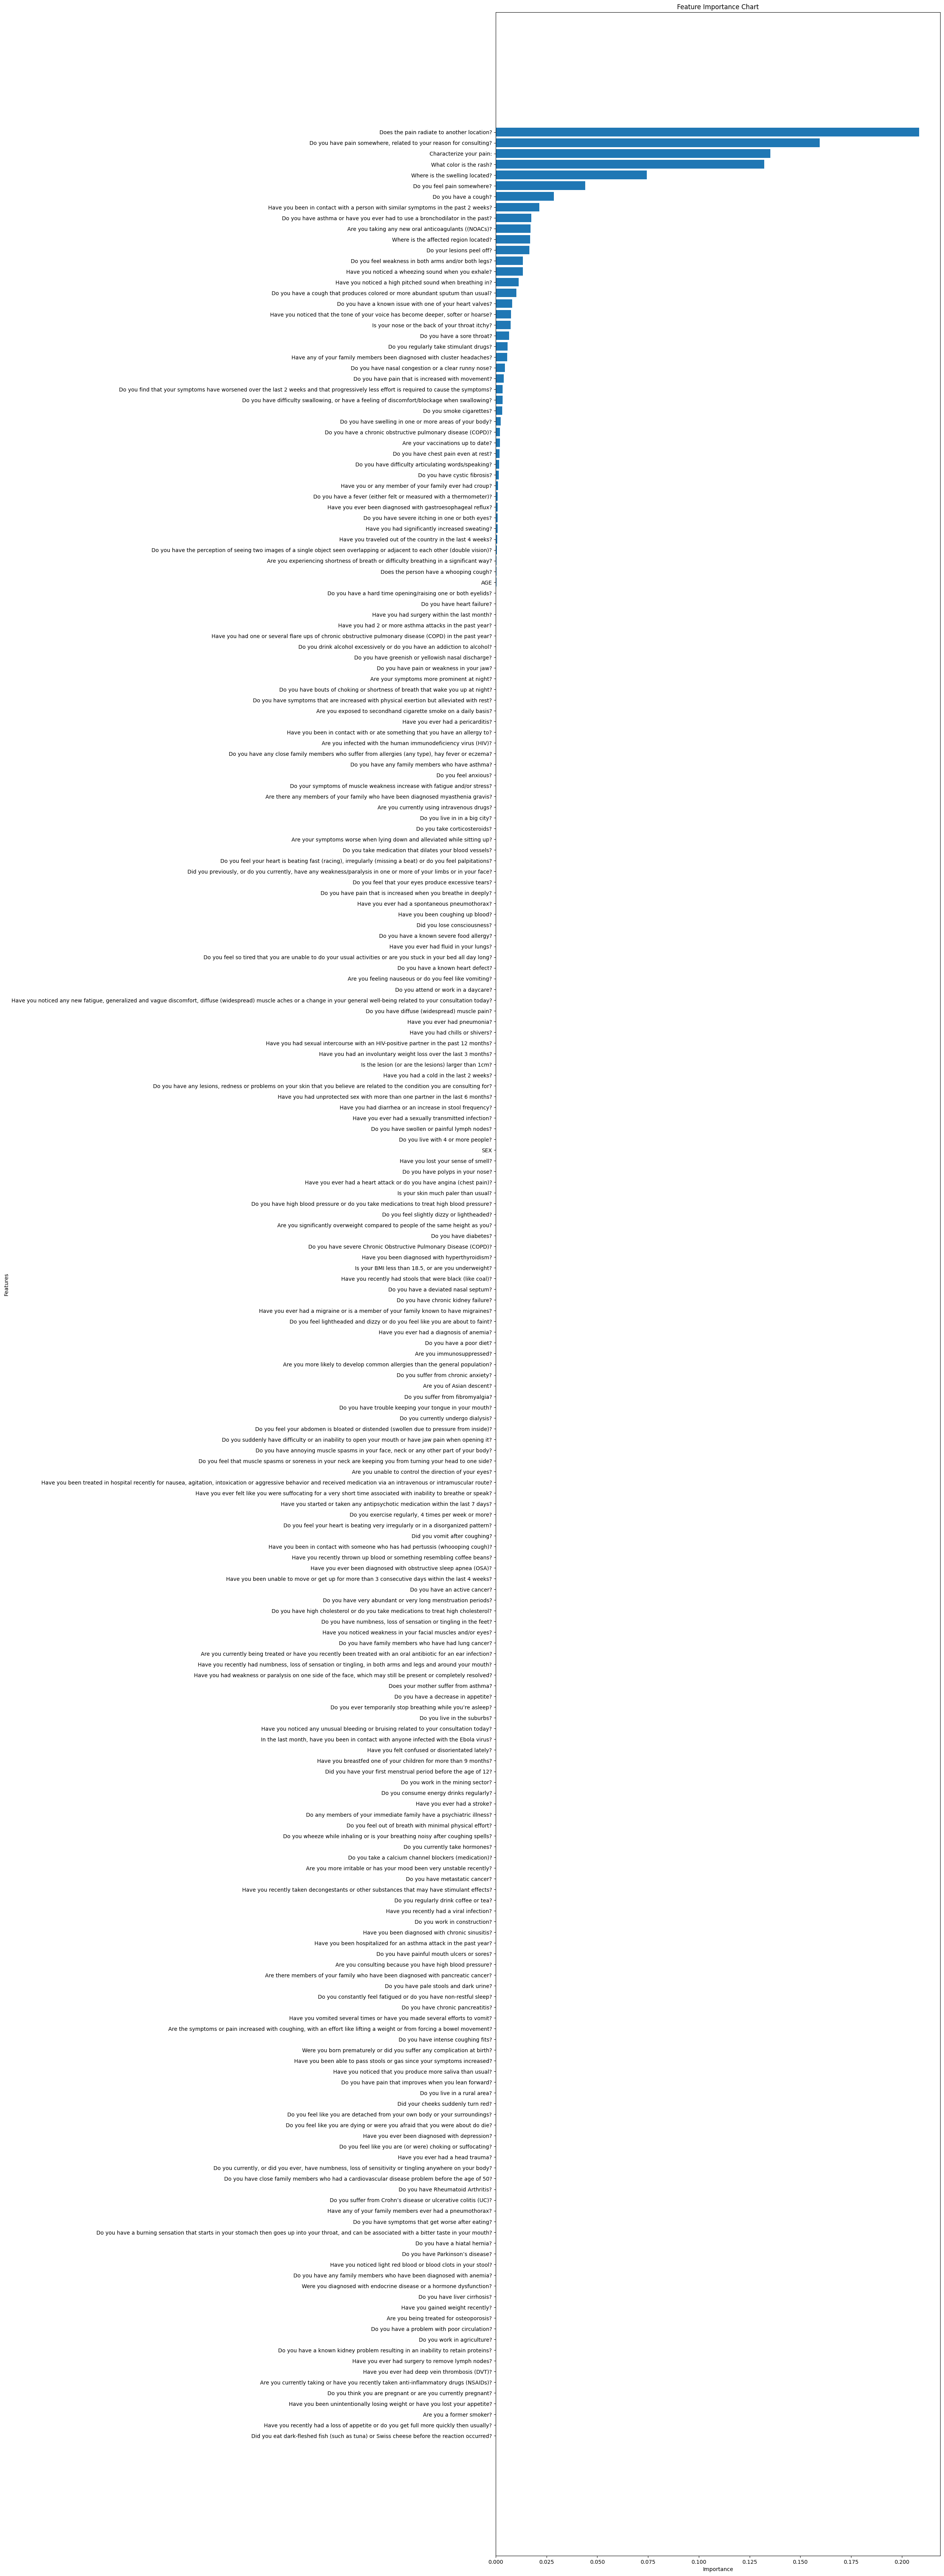

In [27]:
# Get Feature Importance
best_tree = random_search.best_estimator_
feature_importances = best_tree.feature_importances_

# sort feature  importance in descending order
sorted_index = np.argsort(feature_importances)

# create labels
features = np.array(X.columns)

# plot the features
plt.figure(figsize=(15,len(features)*0.4))
plt.title('Feature Importance Chart')
plt.barh(features[sorted_index], feature_importances[sorted_index])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [28]:
# Get features above given threshold importance
importances = random_search.best_estimator_.feature_importances_
threshold = 0.001
important_indices = np.where(importances > threshold)[0]
important_features = features[important_indices ]
print(important_features)
print(len(important_features))

['Do you have pain somewhere, related to your reason for consulting?'
 'Characterize your pain:' 'Do you feel pain somewhere?'
 'Does the pain radiate to another location?'
 'Do you have a cough that produces colored or more abundant sputum than usual?'
 'Do you smoke cigarettes?'
 'Do you have a fever (either felt or measured with a thermometer)?'
 'Do you have a sore throat?' 'Do you have a cough?'
 'What color is the rash?' 'Do your lesions peel off?'
 'Where is the affected region located?'
 'Do you have a chronic obstructive pulmonary disease (COPD)?'
 'Do you have asthma or have you ever had to use a bronchodilator in the past?'
 'Do you have nasal congestion or a clear runny nose?'
 'Have you been in contact with a person with similar symptoms in the past 2 weeks?'
 'Are you taking any new oral anticoagulants ((NOACs)?'
 'Do you have a known issue with one of your heart valves?'
 'Is your nose or the back of your throat itchy?'
 'Have you noticed a high pitched sound when breath

In [29]:
# Perform Cross Validation -- Took 2 minutes
from sklearn.model_selection import cross_validate

# Initialize the model
clf = DecisionTreeClassifier(random_state=420, class_weight='balanced')

# Perform cross validation
cv_results = cross_validate(clf, X_train_encoded, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr', 'roc_auc_ovo'], return_estimator=True)

# Print the mean scores
print(f'Mean Accuracy: {cv_results["test_accuracy"].mean() * 100:.2f}%')
print(f'Mean ROC_AUC OVR: {cv_results["test_roc_auc_ovr"].mean() * 100:.2f}%')
print(f'Mean ROC_AUC OVO: {cv_results["test_roc_auc_ovo"].mean() * 100:.2f}%')
print(f'Mean Precision: {cv_results["test_precision_macro"].mean() * 100:.2f}%')
print(f'Mean Recall: {cv_results["test_recall_macro"].mean() * 100:.2f}%')
print(f'Mean F1 Score: {cv_results["test_f1_macro"].mean() * 100:.2f}%')

Mean Accuracy: 99.17%
Mean ROC_AUC OVR: 99.51%
Mean ROC_AUC OVO: 99.51%
Mean Precision: 99.00%
Mean Recall: 99.02%
Mean F1 Score: 99.01%


In [30]:
for idx, model in enumerate(cv_results['estimator']):
    # Extract feature importances
    importances = model.feature_importances_

    # Get the feature names
    print(f'Model {idx}')
    feature_names = X_train.columns

    # Create a DataFrame for the importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

# Sort the DataFrame by the importances
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance.head(50))

Model 0
Model 1
Model 2
Model 3
Model 4
                                               Feature  Importance
7           Does the pain radiate to another location?    0.104537
20                             What color is the rash?    0.063842
6                          Do you feel pain somewhere?    0.056246
5                              Characterize your pain:    0.053183
21                           Do your lesions peel off?    0.042561
78                      Where is the swelling located?    0.042561
72   Have you noticed a high pitched sound when bre...    0.034336
99   Have you recently had numbness, loss of sensat...    0.023312
13   Have you traveled out of the country in the la...    0.021402
4    Do you have pain somewhere, related to your re...    0.021281
142  Do you have pain that is increased with movement?    0.021198
173                      Did you vomit after coughing?    0.020721
77   Do you have swelling in one or more areas of y...    0.020718
12                    

In [ ]:
# Generate Dataframe Exports
def export_df_to_png(df, filename="dataframe.png"):
    # Set up the canvas with a specified DPI
    fig, ax = plt.subplots(figsize=(15, 12), dpi=300)

    # Use table to render the DataFrame
    tbl = ax.table(cellText=df.values,
                   colLabels=df.columns,
                   cellLoc = 'center',
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)  # Adjust fontsize to your need
    tbl.auto_set_column_width(col=list(range(len(df.columns))))  # Provide automatic column width
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplots_adjust(left=0, top=1, right=1, bottom=0)

    # Save the image
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.close()

def dataframe_summary(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': [df[col].dtype for col in df.columns],
        'Unique Values': [df[col].unique() for col in df.columns]
    })
    return summary

In [ ]:
# Train Data Description
train_columns = [col for col in train_df_nonan.columns if col not in ['Unnamed: 0']]
train_data = train_df_nonan[train_columns]
train_data_summary = dataframe_summary(train_data)
# export_df_to_png(train_data_summary, 'train_data_summary.png') -- NOT HELPFUL
train_data_summary.to_csv('train_data_summary.csv')